# Testing Deep Learning Models

Deep learning models have many hyperparameters and different ways of optimising the parameters, I try to survey some methods in this notebook

- [Check no. of parameters of different blocks](#Check-no.-of-parameters-of-different-blocks)

In [21]:
from keras.models import Model
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.utils import plot_model
from keras.layers.merge import concatenate
from keras.initializers import glorot_uniform
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import tensorflow as tf

import numpy as np

## Check no. of parameters of different blocks

Researchers have conceptualised different blocks and stack them to create a deep neural network and some of them has worked quite well. This section surveys some of these "blocks"

### VGG Block

Model: "VGG_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


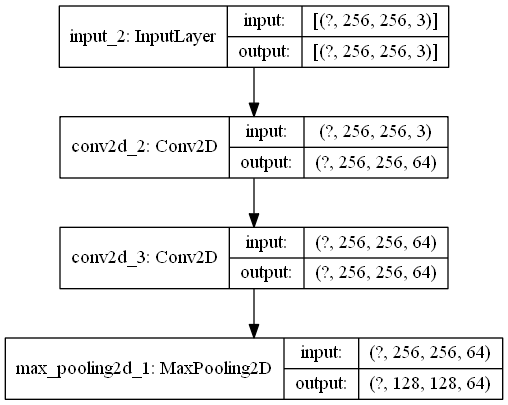

In [4]:
def vgg_block(layer_in, n_filters, n_conv):
    '''
    function for creating a VGG block
    '''
    # add convolutional layers
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
    # add max pooling layer
    layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    return layer_in

# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = vgg_block(visible, 64, 2)
# create model
model = Model(inputs=visible, outputs=layer, name="VGG_block")
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True)

### Inception Module

In [19]:
def naive_inception_module(layer_in, f1, f2, f3):
    '''
    function for creating an inception module
    '''
    
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
    # 5x5 conv
    conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return layer_out

Model: "naive_inception_module"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 256         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 256, 256, 128 3584        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 32) 2432        input_6[0][0]                    
_____________________________________________________________________________

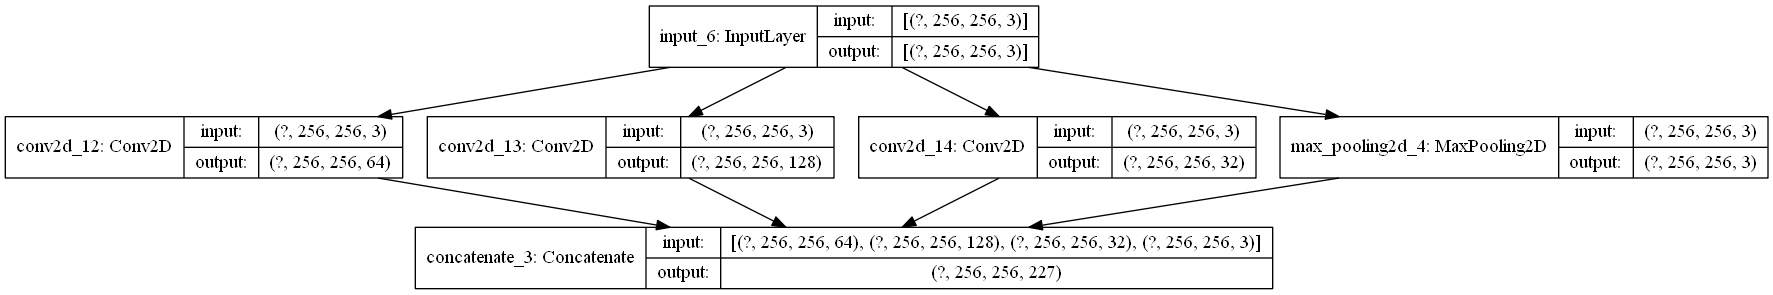

In [26]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception module
layer = naive_inception_module(visible, 64, 128, 32)
# create model
model = Model(inputs=visible, outputs=layer, name="naive_inception_module")
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True)

In [24]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    return layer_out

Model: "inception_module"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 96) 384         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 64          input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 256, 256, 3)  0           input_7[0][0]                    
___________________________________________________________________________________

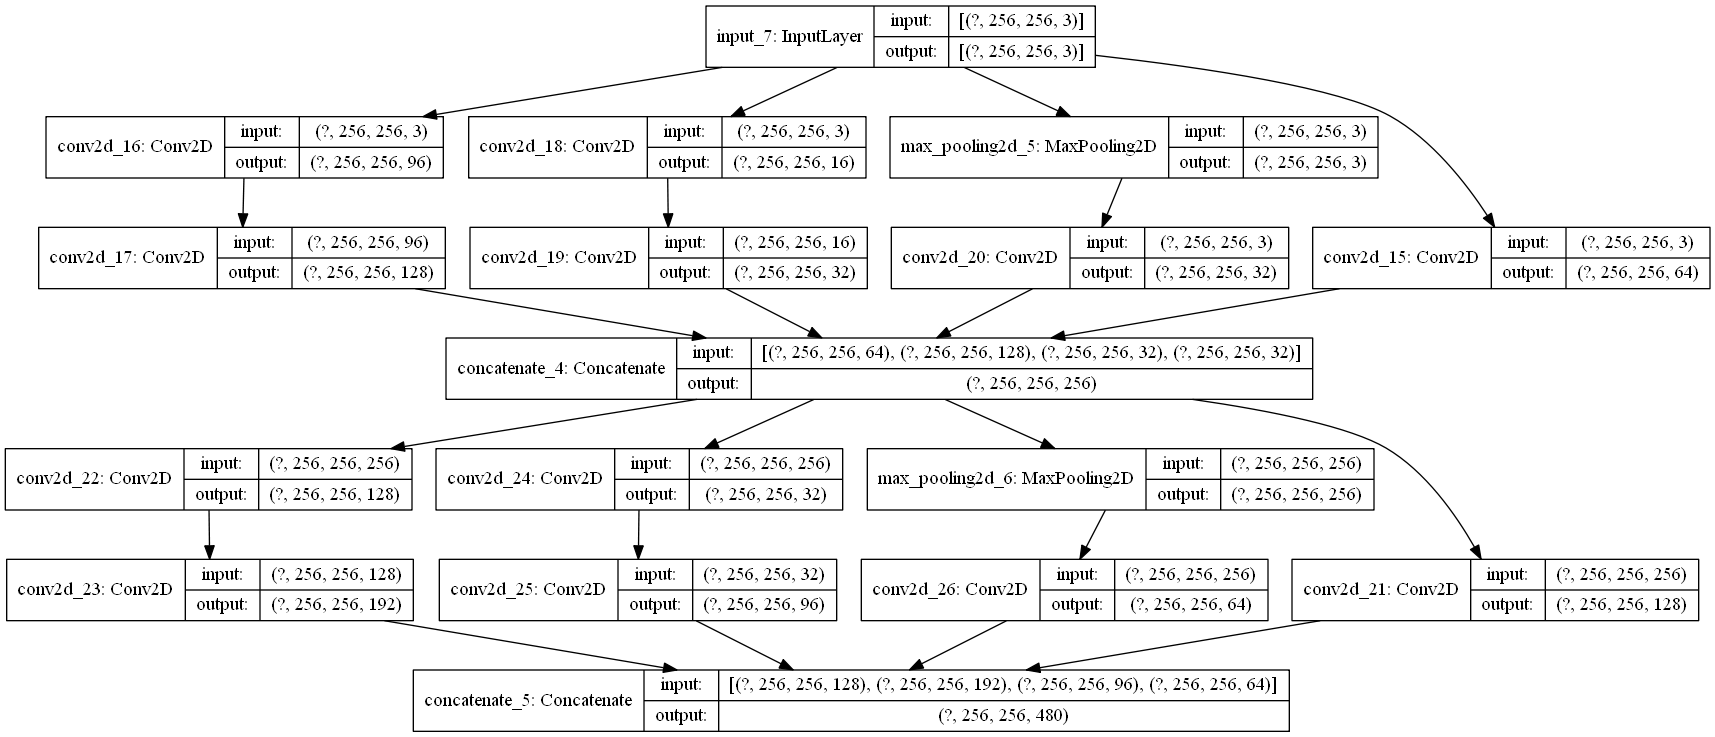

In [27]:
# define model input
visible = Input(shape=(256, 256, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 1
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)
# create model
model = Model(inputs=visible, outputs=layer, name="inception_module")
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True)

### Residual Block

Multiple residual blocks are stacked together and used in ResNet.

Here are the individual steps to build a residual block.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the 'channels' axis.  Its name should be `bn_name_base + '2c'`. 
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Exercise**: Implement the ResNet identity block. We have implemented the first component of the main path. Please read this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- To implement BatchNorm: [BatchNormalization](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/) (axis: Integer, the axis that should be normalized (typically the 'channels' axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://keras.io/layers/merge/#add)

In [10]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
        
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation("relu")(X)
    
    return X

In [16]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as test:
    np.random.seed(1)
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.        0.        1.3454674 2.031818  0.        1.3246754]


In [30]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = Add()([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)

    return layer_out

Model: "residual_block"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 256, 256, 64) 256         input_9[0][0]                    
_____________________________________________________________________________________

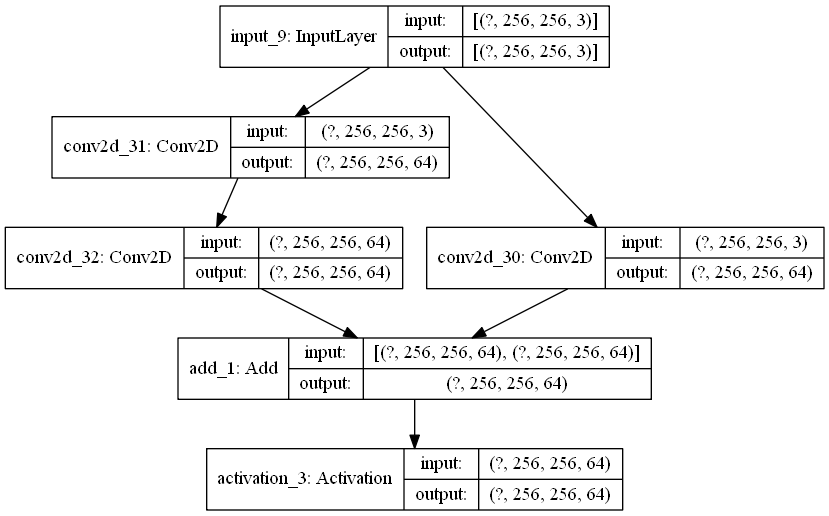

In [31]:
# define model input
visible = Input(shape=(256, 256, 3))
# add vgg module
layer = residual_module(visible, 64)
# create model
model = Model(inputs=visible, outputs=layer, name="residual_block")
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True)